In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dogs-vs-cats #had to accept the term and conditions of the competition

In [0]:
!unzip train.zip
!unzip test1.zip

In [0]:
%matplotlib inline

import pandas as pd
import torch
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import helper
from skimage import io
from PIL import Image
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


In [0]:
df = pd.read_csv('sampleSubmission.csv')
df.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
dirpath = os.getcwd()

## Prepare

In [0]:
trainpath = Path(dirpath)/'train'
testpath = Path(dirpath)/'test1'
# !ls {testpath}

In [0]:
class DogCatDataset(Dataset):
    def __init__(self, datafolder, transform):
        self.datafolder = datafolder
        self.image_files_list, self.label_list = zip(*[(s, 1.0) if s.startswith('cat') 
                                                       else (s, 0.0) if s.startswith('dog') 
                                                       else (s, -1.0) for s in os.listdir(datafolder)])
        self.label_list = torch.Tensor(np.array(self.label_list))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder,self.image_files_list[idx])
        image = io.imread(img_name)
        image = Image.fromarray(image)
        image = self.transform(image)
        return image, self.label_list[idx]

In [0]:
valid_size = 0.2

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])


train_data = DogCatDataset(str(trainpath), transform=train_transforms)
test_data = DogCatDataset(str(testpath), transform=test_transforms)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

## See the Cute Data

https://matplotlib.org/users/image_tutorial.html

In [0]:
test_iter = iter(testloader)

In [0]:
train_iter = iter(trainloader)

In [0]:
def show(data_iter,test=True, num=5):

    images, labels = next(data_iter)
    
    def denormalize(image):
#         mean = torch.Tensor([0.485, 0.456, 0.406])
#         std = torch.Tensor([0.229, 0.224, 0.225])
        mean = torch.Tensor([0.5, 0.5, 0.5])
        std = torch.Tensor([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        return image
        
    fig, axes = plt.subplots(figsize=(10,4), ncols=num)
    
    for ii in range(num):
        ax = axes[ii]
        img = images[ii].permute((1, 2, 0))
        
        if not test:
            img = denormalize(img)
            
        ax.imshow(img)

        if labels[ii]==1:
          itis="cat"
        elif labels[ii]==0:
          itis="dog"
        else:
          itis="unknown"

        ax.title.set_text(itis)
        ax.axis('off')

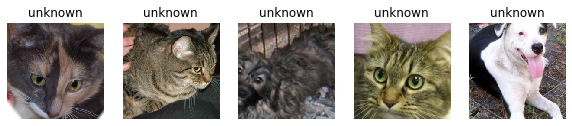

In [0]:
show(test_iter)

## View the various transofrmations on the same batch(better w/o shuffling trainloader)

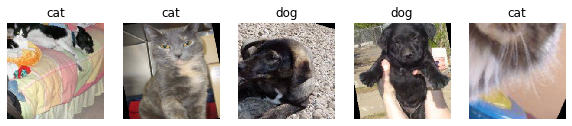

In [0]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

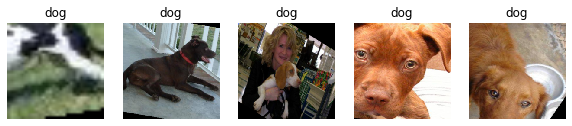

In [0]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

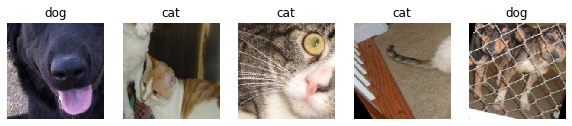

In [0]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

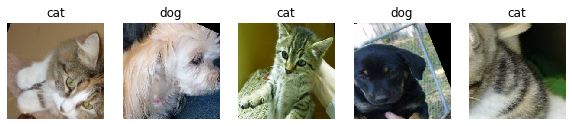

In [0]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

In [0]:
see = next(train_iter)

In [0]:
see[0].shape

torch.Size([64, 3, 224, 224])

In [0]:
see[1]

tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 0., 1.])

In [0]:
see[1].shape

torch.Size([64])

## The Model

In [0]:
device = 'cuda'

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
class net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,kernel_size=7)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=7)
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5)
    self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5)
    self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(in_features=123904,out_features=512)
    self.fc2 = nn.Linear(in_features=512,out_features=128)
    self.fc3 = nn.Linear(in_features=128,out_features=32)
    self.out = nn.Linear(in_features=32, out_features=1)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.pool(F.relu(self.conv5(x)))
    x = x.reshape(x.shape[0],-1)
    # print(x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.out(x))
    return x

In [0]:
model = net().to(device)

In [0]:
# model = net()
# model(see[0])

In [0]:
optimizer = optim.Adam(model.parameters(),0.001)

## Utils

In [0]:
def num_correct(preds,labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
def accuracy(preds,labels):
  return num_correct(preds,labels)*100.0/len(preds)

## Train

In [0]:
25000/64/50

7.8125

In [0]:
num_epochs = 5
count = 0
iteration_list = []
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

In [0]:
for epoch in range(1,num_epochs+1):
  
  train_loss = 0
  train_correct = 0
  train_num = 0

  for i,(images,labels) in enumerate(trainloader):

    ##--------------------------training--------------------------
    model.train()
    images = images.to(device)
    labels = labels.unsqueeze(1).to(device)
    output = model(images)
    loss   = F.binary_cross_entropy(output,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count+=1
    train_loss+=loss.item()
    train_num+=len(labels)
    train_correct+=num_correct(output,labels[0])

    ##--------------------------validating--------------------------
    if count%20==0:
      valid_loss = 0
      valid_correct = 0
      valid_num = 0 
      with torch.no_grad():
        model.eval()
        for images,labels in validloader:
          images = images.to(device)
          labels = labels.unsqueeze(1).to(device)
          output = model(images)
          loss   = F.binary_cross_entropy(output,labels)
          valid_loss+=loss.item()
          valid_correct+=num_correct(output,labels[0])
          valid_num+=len(labels)
      valid_loss/=len(validloader)
      valid_correct/=float(valid_num)

      iteration_list.append(count)
      train_loss_list.append(train_loss/count)
      valid_loss_list.append(valid_loss)
      train_acc_list.append(100.0*train_correct/float(train_num))
      valid_acc_list.append(100.0*valid_correct)

      if count%50==0:
        print("Iter {} Epoch {}  train loss: {:.2f}  train acc: {:.2f} valid loss: {:.2f}  valid acc: {:.2f}"
        .format(i,epoch,train_loss_list[-1],train_acc_list[-1],valid_loss_list[-1],valid_acc_list[-1]))

print("Training Over!")

Iter 99 Epoch 1  train loss: 0.71  train acc: 59.00 valid loss: 0.69  valid acc: 34.72
Iter 199 Epoch 1  train loss: 0.70  train acc: 53.50 valid loss: 0.69  valid acc: 55.04
Iter 299 Epoch 1  train loss: 0.70  train acc: 50.67 valid loss: 0.69  valid acc: 59.04
Iter 86 Epoch 2  train loss: 0.15  train acc: 50.57 valid loss: 0.69  valid acc: 50.08
Iter 186 Epoch 2  train loss: 0.26  train acc: 54.01 valid loss: 0.69  valid acc: 52.64
Iter 286 Epoch 2  train loss: 0.33  train acc: 48.08 valid loss: 0.69  valid acc: 51.20
Iter 73 Epoch 3  train loss: 0.07  train acc: 50.00 valid loss: 0.69  valid acc: 48.80
Iter 173 Epoch 3  train loss: 0.15  train acc: 51.72 valid loss: 0.69  valid acc: 57.76


In [0]:
# visualization loss 
plt.plot(iteration_list,train_loss_list,label='train')
plt.plot(iteration_list,valid_loss_list,label='valid')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,train_acc_list,label='train')
plt.plot(iteration_list,valid_acc_list,label='valid')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.legend()
plt.show()

## Prediction

In [0]:
len(train_data), len(test_data)

In [0]:
def get_all_preds(model, loader):
  all_preds = torch.tensor([]).to('cuda')
  for images, labels in loader:
    images = images.to('cuda')
    labels = labels.to('cuda')
    preds = model(images)
    all_preds = torch.cat((all_preds,preds),dim=0) #appending the predictions
  return all_preds

In [0]:
with torch.no_grad():
  preds = get_all_preds(model,testloader)
  preds.shape

In [0]:
df.label = preds.squeeze()

In [0]:
df.label.sum()/len(df)

In [0]:
df.to_csv('submit.csv')